# Vgg model from scratch with Statefarm Distracted Driver data

#### To do before running the notebook
- Download data and unzip

In [1]:
# Path containing unzipped data
DATA_DIR = '/Users/stephanrasp/repositories/courses/data/statefarm/'   # Mac

#### Step 1: Set up folder structure with sample data
- The folder structure is already good, each category has its own directory. This means we need to do:
- Create validation set
- Then create sample 

```
DATA_DIR/
    test/
        unknown/ - Need to move those
            img_<num>.jpg
    train/
        c0/
        ...
        c9/
            img_<num>.jpg
    [We need to create and move files]
    valid/
        c0/
        ...
        c9/
            img_<num>.jpg - valid_size
    [And then copy]
    sample/
        train/
            c0/
            ...
            c9/
                img_<num>.jpg - sample_train_size
        valid/
            c0/
            ...
            c9/
                img_<num>.jpg - sample_valid_size
        test/
            unknown/ - Need to move those
                img_<num>.jpg
```

In [2]:
# How much data is there in each category
import glob
for i in range(10):
    print('Category %i contains %i' %(i, len(glob.glob(DATA_DIR + '/train/c%i/*' % i))))
print('Test set contains %i' %(len(glob.glob(DATA_DIR + '/test/*'))))

Category 0 contains 2489
Category 1 contains 2267
Category 2 contains 2317
Category 3 contains 2346
Category 4 contains 2326
Category 5 contains 2312
Category 6 contains 2325
Category 7 contains 2002
Category 8 contains 1911
Category 9 contains 2129
Test set contains 71716


In [3]:
# Pretty evenly distributed, so we don't need to worry about it.
for i in range(10):
    stri = str(i)
    %mkdir -p $DATA_DIR/valid/c$stri
    %mkdir -p $DATA_DIR/sample/valid/c$stri
    %mkdir -p $DATA_DIR/sample/train/c$stri
%mkdir -p $DATA_DIR/sample/test/unknown
%mkdir -p $DATA_DIR/test/unknown

In [12]:
# If not on mac this might work
# %mv $DATA_DIR/test/*.jpg $DATA_DIR/test/unknown
# On the mac we have to do something like this... which is stupid since I don't even need the entire data set
import os
test_fns = glob.glob(DATA_DIR + 'test/*.jpg')
print test_fns
for fn in test_fns:
    os.system('mv %s %s' %(fn, DATA_DIR + 'test/unknown/'))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [17]:
'/Users/stephanrasp/tmp/mv.txt'.split('/')[-1]

'mv.txt'

In [20]:
# Move valid files
valid_size = 400   # Roughly 80-20
import numpy as np
for i in range(10):
    fns = glob.glob(DATA_DIR + 'train/c%i/*.jpg' % i)
    shuf = np.random.permutation(fns)
    for j in range(valid_size): os.rename(shuf[j], DATA_DIR + 'valid/c%i/%s' % (i, shuf[j].split('/')[-1]))

In [22]:
# Copy sample files
sample_train_size = 100
sample_valid_size = 20
sample_test_size = 100
from shutil import copyfile
for i in range(10):
    fns = glob.glob(DATA_DIR + 'valid/c%i/*.jpg' % i)
    shuf = np.random.permutation(fns)
    for j in range(sample_valid_size): copyfile(shuf[j], DATA_DIR + 'sample/valid/c%i/%s' % (i, shuf[j].split('/')[-1]))

In [23]:
for i in range(10):
    fns = glob.glob(DATA_DIR + 'train/c%i/*.jpg' % i)
    shuf = np.random.permutation(fns)
    for j in range(sample_train_size): copyfile(shuf[j], DATA_DIR + 'sample/train/c%i/%s' % (i, shuf[j].split('/')[-1]))

In [24]:
fns = glob.glob(DATA_DIR + 'test/unknown/*.jpg')
shuf = np.random.permutation(fns)
for j in range(sample_test_size): copyfile(shuf[j], DATA_DIR + 'sample/test/unknown/%s' % shuf[j].split('/')[-1])

all done I think, let's set the model up with the sample data

In [25]:
DATA_DIR_SAMPLE = DATA_DIR + 'sample/'

#### Step 2: Try loading and visualizing the data

In [26]:
sample_file = glob.glob(DATA_DIR_SAMPLE + 'train/c0/*.jpg')[0]

In [30]:
from keras.preprocessing import image
img = image.load_img(sample_file)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
plt.imread(sample_file).shape

(480, 640, 3)

In [41]:
def plot_4ims(ims):
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    for im, ax in zip(ims, axes):
        ax.imshow(im)
    plt.show()

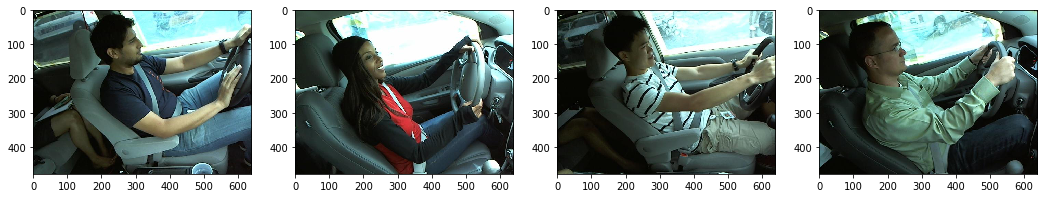

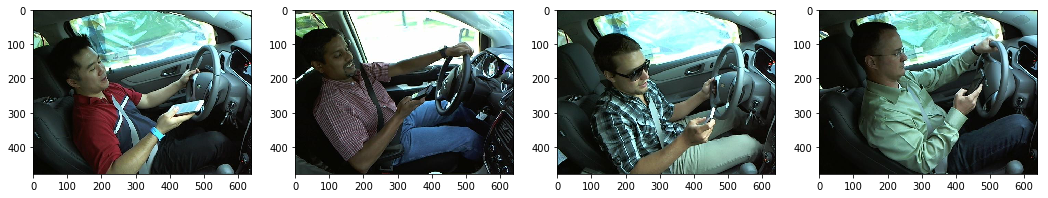

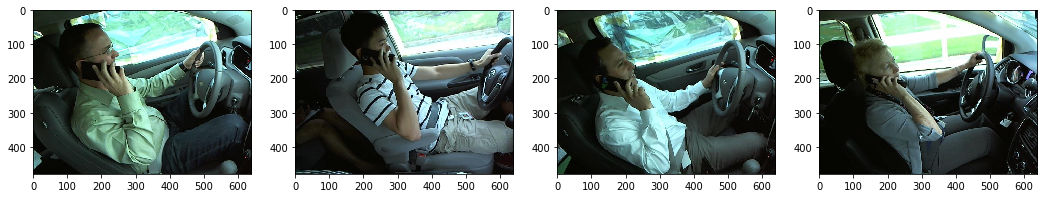

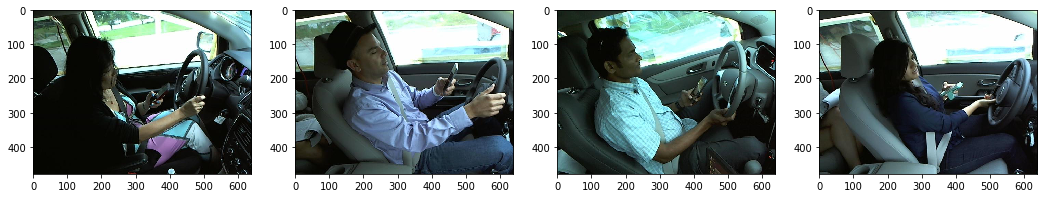

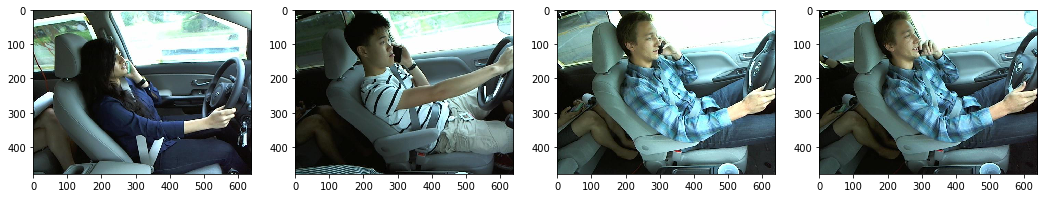

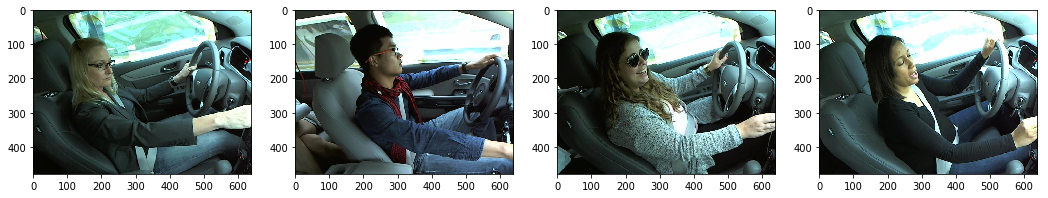

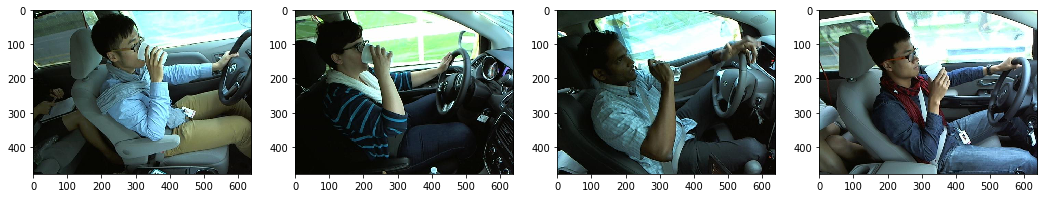

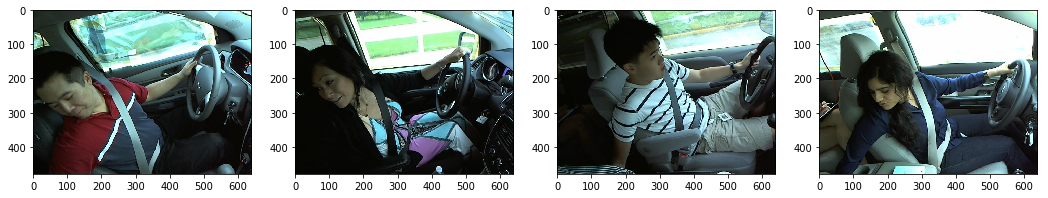

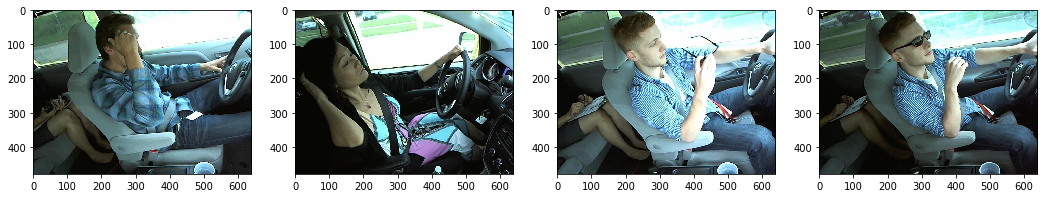

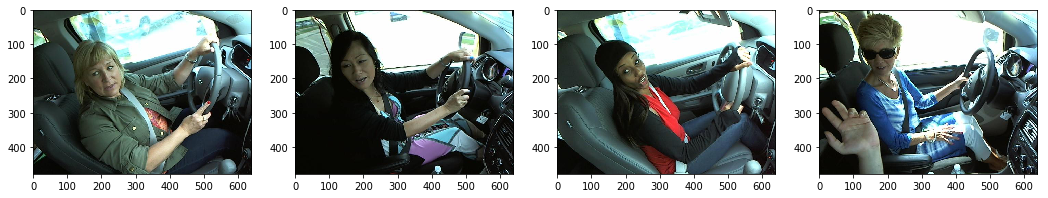

In [42]:
for i in range(10):
    fns = glob.glob(DATA_DIR_SAMPLE + 'train/c%i/*.jpg' % i)
    ims = [plt.imread(fn) for fn in fns[:4]]
    plot_4ims(ims)

#### Step 3: What needs to be done to preprocess the data for VGG?
- VGG has bgr instead of rgb --> in lambda preprocessing
- Subtract mean value (needs to be listed) --> In lambda preprocessing
- Has image shape 3x224x224 --> in get_batches

#### Step 4: Set up the Vgg16 model

In [61]:
# Create the Keras model
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.models import Sequential

model = Sequential()

In [62]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Total params: 0
Trainable params: 0
Non-trainable params: 0
____________________________________________________________________________________________________


In [63]:
# First step is preprocessing, so let's write a routine like in the Vgg class
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    # x is the image (but in what format???)
    x = x - vgg_mean
    return x[:, ::-1]

So Vgg has input size3x224x224 (channels, width, height)

In [64]:
# Ok so, I don't get that yet, but we will continue...
# What is this lambda: Just applies a function I guess
from keras.layers.core import Lambda

In [65]:
model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))

In [66]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
Total params: 0
Trainable params: 0
Non-trainable params: 0
____________________________________________________________________________________________________


So now we actually need to check out the model structure and build the model.

In [67]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [68]:
def add_conv_block(model, conv_layers, filters):
    for i in range(conv_layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [69]:
add_conv_block(model, 2, 64)
add_conv_block(model, 2, 128)
add_conv_block(model, 3, 256)
add_conv_block(model, 3, 512)
add_conv_block(model, 3, 512)

In [70]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [71]:
# Now transition to fully connected
from keras.layers.core import Flatten 
model.add(Flatten())

In [72]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [74]:
from keras.layers.core import Dense, Dropout
def add_fc_block(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [75]:
add_fc_block(model)
add_fc_block(model)

In [77]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [78]:
# The final softmax layer (will not use this in the end but probably need it to load the weights...)
model.add(Dense(1000, activation='softmax'))

In [80]:
# Now load the weights
from keras.utils.data_utils import get_file
fn = 'vgg16.h5'
model.load_weights(get_file(fn, 'http://files.fast.ai/models/' + fn, cache_subdir='models'))

In [83]:
# Let's also load the inital imagenet classes
import json
fn = 'imagenet_class_index.json'
# Aha the cache is in the .keras directory, clever
fpath = get_file(fn, 'http://files.fast.ai/models/' + fn, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)

In [89]:
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [90]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

#### Step 5: Make a prediction with the raw model for the statefarm data

In [91]:
# Do this batches stuff
# so it works with this image data generator 
gen = image.ImageDataGenerator()

In [92]:
batch_size = 4
test_batches = gen.flow_from_directory(DATA_DIR_SAMPLE + 'test', target_size=(224, 224), 
                                       class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 100 images belonging to 1 classes.


In [93]:
test_batches.nb_sample

100

In [95]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [96]:
preds.shape

(100, 1000)

In [97]:
# Convert that to actual predictions and then plot
highest_idx = np.argmax(preds, axis=1)
preds_prob = [preds[i, highest_idx[i]] for i in range(len(highest_idx))]
highest_classes = [classes[i] for i in highest_idx] 

In [99]:
ims, l = next(test_batches)

In [102]:
ims.shape


(4, 3, 224, 224)

In [113]:
ims_list = [np.rollaxis(ims[i], 0, 3)[:, :, ::-1] for i in range(4)]
ims_list[0].shape

(224, 224, 3)

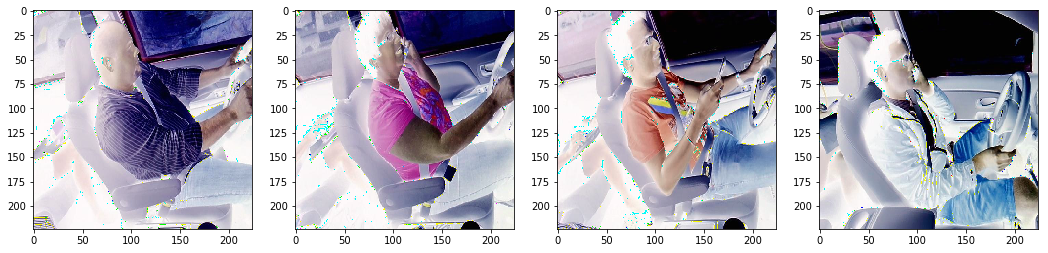

([u'seat_belt', u'seat_belt', u'seat_belt', u'seat_belt'], [0.93736321, 0.86447173, 0.35473928, 0.3565371])


In [114]:
plot_4ims(ims_list)
print(highest_classes[:4], preds_prob[:4])

Ok So I am not so sure what is going on with the colors. But hey I made a prediction... yay. Seatbelts..

#### Step 6: Modify the model for the new task
- Pop the last layer, preserve the rest and add a new final fully connected layer

In [115]:
# Pop the last layer
model.pop()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [117]:
for layer in model.layers:
    layer.trainable = False

In [118]:
# Get some example batches from the train set
train_batches = gen.flow_from_directory(DATA_DIR_SAMPLE + 'train', target_size=(224, 224), 
                                       class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 1000 images belonging to 10 classes.


In [119]:
model.add(Dense(train_batches.nb_class, activation='softmax'))

In [120]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

#### Step 7: Compile the model and train the new last network

In [122]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
# Additionally get validation batchs
valid_batches = gen.flow_from_directory(DATA_DIR_SAMPLE + 'valid', target_size=(224, 224), 
                                       class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 200 images belonging to 10 classes.


In [124]:
model.fit_generator(train_batches, train_batches.nb_sample, 1, 
                    validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample)

Epoch 1/1
1000/1000 [==============================] - 1051s - loss: 3.8378 - acc: 0.2080 - val_loss: 1.7709 - val_acc: 0.4400


In [125]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [130]:
preds[:5]

array([[  2.64097216e-05,   3.85633297e-03,   2.81977663e-07,
          8.39336062e-05,   2.54662555e-05,   9.92570162e-01,
          4.29061265e-06,   1.45315120e-04,   2.06131046e-03,
          1.22648885e-03],
       [  3.96980532e-03,   2.99163791e-03,   2.83844143e-01,
          2.14969143e-02,   5.71974039e-01,   2.71064043e-02,
          1.95466913e-03,   9.94318998e-06,   7.95402676e-02,
          7.11219385e-03],
       [  1.64981093e-02,   9.72542260e-03,   2.78411172e-02,
          6.57164752e-02,   7.30920255e-01,   3.65969315e-02,
          1.05378451e-02,   6.55296972e-05,   1.00580260e-01,
          1.51806546e-03],
       [  2.92367069e-03,   3.06799505e-02,   5.59451973e-06,
          9.17072654e-01,   6.18425384e-03,   1.63998846e-02,
          4.00099059e-04,   2.32235529e-03,   1.33499335e-02,
          1.06616085e-02],
       [  3.04613024e-01,   1.34667158e-01,   5.67494296e-02,
          5.94026893e-02,   1.03677817e-01,   3.05573761e-01,
          5.17558912e-03

In [155]:
sub_ids = [int(fn.rstrip('.jpg').lstrip('unknown/img_')) for 
           fn in test_batches.filenames]

In [156]:
preds.shape

(100, 10)

In [157]:
sub_ids = np.array(sub_ids)

In [158]:
sub_ids = np.reshape(sub_ids, (100, 1))

In [159]:
sub_cols = np.append(sub_ids, preds, 1)

In [160]:
sub_cols[:5]

array([[  1.00990000e+05,   2.64097216e-05,   3.85633297e-03,
          2.81977663e-07,   8.39336062e-05,   2.54662555e-05,
          9.92570162e-01,   4.29061265e-06,   1.45315120e-04,
          2.06131046e-03,   1.22648885e-03],
       [  1.02560000e+04,   3.96980532e-03,   2.99163791e-03,
          2.83844143e-01,   2.14969143e-02,   5.71974039e-01,
          2.71064043e-02,   1.95466913e-03,   9.94318998e-06,
          7.95402676e-02,   7.11219385e-03],
       [  1.07200000e+03,   1.64981093e-02,   9.72542260e-03,
          2.78411172e-02,   6.57164752e-02,   7.30920255e-01,
          3.65969315e-02,   1.05378451e-02,   6.55296972e-05,
          1.00580260e-01,   1.51806546e-03],
       [  1.38960000e+04,   2.92367069e-03,   3.06799505e-02,
          5.59451973e-06,   9.17072654e-01,   6.18425384e-03,
          1.63998846e-02,   4.00099059e-04,   2.32235529e-03,
          1.33499335e-02,   1.06616085e-02],
       [  1.42610000e+04,   3.04613024e-01,   1.34667158e-01,
          5.67

In [147]:
sub_fn = 'test_submission.csv'
%mkdir -p $DATA_DIR/submission

In [163]:
np.savetxt(DATA_DIR + 'submission/' + sub_fn, sub_cols, fmt='img_%d,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f',
           header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

In [164]:
from IPython.display import FileLink
FileLink(DATA_DIR + 'submission/' + sub_fn)

/Users/stephanrasp/repositories/courses/data/statefarm/submission/test_submission.csv